# Trabajo Práctico N°3: Análisis Descriptivo y Predicción de Desocupación 
## Alumnos: Manuel Díaz de la Fuente, Diego Fernández Meijide y Sofía Kastika

## Parte I: Análisis Descriptivo 

El objetivo de esta parte del trabajo es el de la realización de un análisis descriptivo utilizando datos de la Encuesta Permanente de Hogares (EPH)

### Importamos librerías

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Ejercicio 1

La explicación de desocupación se encuentra presentada en el documento

### Ejercicio 2.A

Objetivos: 
   - Quedarnos con las observaciones correspondientes a nuestro aglomerado Bahía Blanca - Cerri
   - Unir los trimestres de la EPH 2004 y la EPH 2024 en una sola base

In [2]:
eph2004 = pd.read_stata('./input/Individual_t104.dta', convert_categoricals= False) # importamos base 2004
# eph2024 = pd.read_excel('./input/usu_individual_T124.xlsx') # Ya lo guardamos como csv, no hay que cargarlo más como excel
# eph2024.to_csv('./input/usu_individual_T124.csv, index = False)

In [3]:
tipos = eph2004.dtypes.to_dict() # Vemos los dtypes de la base de 2004
# Lo guardamos como diccionario para cuando cargue el csv poder especificarle al read_csv los dtypes de la base de 2024
# Cambiamos los dtypes de las columnas que nos van a a interesar
tipos['ch04'] = 'category'
tipos['estado'] = 'category'
tipos['cat_inac'] = 'category'
tipos['nivel_ed'] = 'category'
tipos['ch07'] = 'category'
tipos['ch08'] = 'category'

# Las asignamos al df
eph2004 = eph2004.astype(tipos)

In [4]:
# Las categorías del 2004 están guardadas como floats cuando deberían ser enteros
categorical_columns = eph2004.select_dtypes(include='category').columns # Seleccionamos las columnas categóricas

for col in categorical_columns: # Iteramos sobre esas columnas
    eph2004[col] = eph2004[col].astype(int) # Las cambiamos para que sean enteros
    
for col in categorical_columns: # Vuelvemos a iterar sobre esas columnas
    eph2004[col] = eph2004[col].astype('category') # Las cambiamos para que vuelvan a ser una categoría

In [5]:
# Para que no salte una advertencia, especificamos el tipo de la columnas que nos interesan
eph2024 = pd.read_csv('./input/usu_individual_T124.csv', dtype = tipos) # Lo cargamos con las categorías correctas

In [6]:
# Para compatibilizar ambas bases hacemos lo mismo que para la de 2004
for col in categorical_columns:
    eph2024[col] = eph2024[col].astype(int) # Las paso a integer

for col in categorical_columns:
    eph2024[col] = eph2024[col].astype('category') # Devuelta las paso a categoría

### Bahía Blanca: Somos el grupo 6, por lo que tenemos que trabajar con Bahía Blanca - Cerri (código: 03)



In [7]:
# Agregamos una variable año a cada df
eph2004 = pd.concat([eph2004, pd.Series(2004, index=eph2004.index, name='año')], axis=1) # Lo hacemos de esta forma porque si no, saltaba una advertencia 
eph2024 = pd.concat([eph2024, pd.Series(2024, index=eph2024.index, name='año')], axis=1)

In [8]:
# Juntamos ambas bases en una única base
data = pd.concat([eph2004, eph2024], ignore_index= True)
data.shape # Vemos cuantas filas y columnas en total

(91339, 183)

El concat modifica los dtypes de las columnas categóricas, por lo que hay que cambiarlos devuelta

In [9]:
# Nos quedamos únicamente con Bahía Blanca
data = data.loc[data['aglomerado'] == 3]
data.shape 

(2164, 183)

### Ejercicio 2.B

Objetivo: 
  - Descartar las observaciones que no tienen sentido (ejemplo: ingresos y edades negativos)

In [10]:
# Eliminamos las observaciones que no tienen sentido
data = data.loc[(data['ch06'] >= 0) & (data['ipcf'] >= 0)] # Solo nos quedamos con las observaciones con edad >= 0 y los ingresos positivos
data.shape

(2142, 183)

### Ejercicio 2.C
Objetivo: 
   - Realizar un gráfico de barras mostrando la composición por sexo para 2004 y 2024


In [11]:
# Como el concat desconfiguró los dtypes, los volvemos a asignar
data['ch04'] = data['ch04'].astype('category')
data['estado'] = data['estado'].astype('category')
data['cat_inac'] = data['cat_inac'].astype('category')
data['nivel_ed'] = data['nivel_ed'].astype('category')
data['ch07'] = data['ch07'].astype('category')
data['ch08'] = data['ch08'].astype('category')

In [12]:
# Le ponemos nombre a los valores de cada categoría
data['ch04'] = data['ch04'].cat.rename_categories({1: "Varón", 2: "Mujer"})
data['estado'] = data['estado'].cat.rename_categories({0: "Entrevista Individual No Realizada", 1: "Ocupado", 2: 'Desocupado', 3:'Inactivo', 4: 'Menor de 10 años'})
data['cat_inac'] = data['cat_inac'].cat.rename_categories({0: 'Activo', 1: "Jubilado/Pensionado", 2: "Rentista", 3: 'Estudiante', 4:'Ama de Casa', 5: 'Menor de 6 años', 6: 'Discapacitado', 7: 'Otros'})
data['nivel_ed'] = data['nivel_ed'].cat.rename_categories({1: "Primario Incompleto", 2: "Primario Completo", 3: 'Secundario Incompleto', 4:'Secundario Completo', 5: 'Superior Universitario Incompleto', 6: 'Superior Universitario Completo', 7: 'Sin Instrucción', 8: 'Ns/Nr'})
data['ch07'] = data['ch07'].cat.rename_categories({1: "Unido", 2: "Casado", 3: 'Separado/Divorciado', 4:'Viudo', 5: 'Soltero'})
data['ch08'] = data['ch08'].cat.rename_categories({1: "Obra Social (incluye PAMI)", 2: "Mutual/Prepaga/Servicio de Emergencia", 3: 'Planes y Seguros Públicos', 4:'No Pagan ni le Descuentan', 9: 'Ns/Nr', 12: 'Obra Social y Mutual/Prepaga/Servicio de Emegencia', 13: 'Obra Social y Planes y Seguros Públicos', 23: 'Mutual/Prepaga/Servicio de Emergencia y Seguros Públicos', 123: 'Obra Social, Mutual/Prepaga/Servicio de Emergencia y Planes y Seguros Públicos'})

### Composición mujeres-varones

In [13]:
data_2004_counts = data.loc[data['año'] == 2004]['ch04'].value_counts(normalize=True) * 100 
data_2024_counts = data.loc[data['año'] == 2024]['ch04'].value_counts(normalize=True) * 100
# Calculamos para cada año el procentaje de varones y el porcentaje de mujeres

In [14]:
# Armamos una función para hacer gráficos de barras que comparen entre años
def composicion_bar(val_2004, val_2024, x_label, output_path = None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6)) # creamos una figura con 2 subplots 

    bars_2004 = axs[0].bar(val_2004.index, val_2004.values, color='skyblue') # creamos gráfico de barra 
    axs[0].set_title('Composición en 2004') # título del gráfico
    axs[0].set_xlabel(x_label) # título eje x 
    axs[0].set_ylabel('Porcentaje') # título eje y 
    axs[0].set_ylim(0, 100) # establecer los límites del eje y entre 0 y 100

    for bar, value in zip(bars_2004, val_2004.values):
        axs[0].text(bar.get_x() + bar.get_width() / 2, value + 2, f'{value:.1f}%', ha='center') # agregamos los porcentajes arriba de cada barra


    bars_2024 = axs[1].bar(val_2024.index, val_2024.values, color='salmon') # creamos gráfico de barra 
    axs[1].set_title('Composición en 2024') # título del gráfico 
    axs[1].set_xlabel(x_label) # título eje x
    axs[1].set_ylim(0, 100) # establecer los límites del eje y entre 0 y 100
    
    for bar, value in zip(bars_2024, val_2024.values):
        axs[1].text(bar.get_x() + bar.get_width() / 2, value + 2, f'{value:.1f}%', ha='center')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()


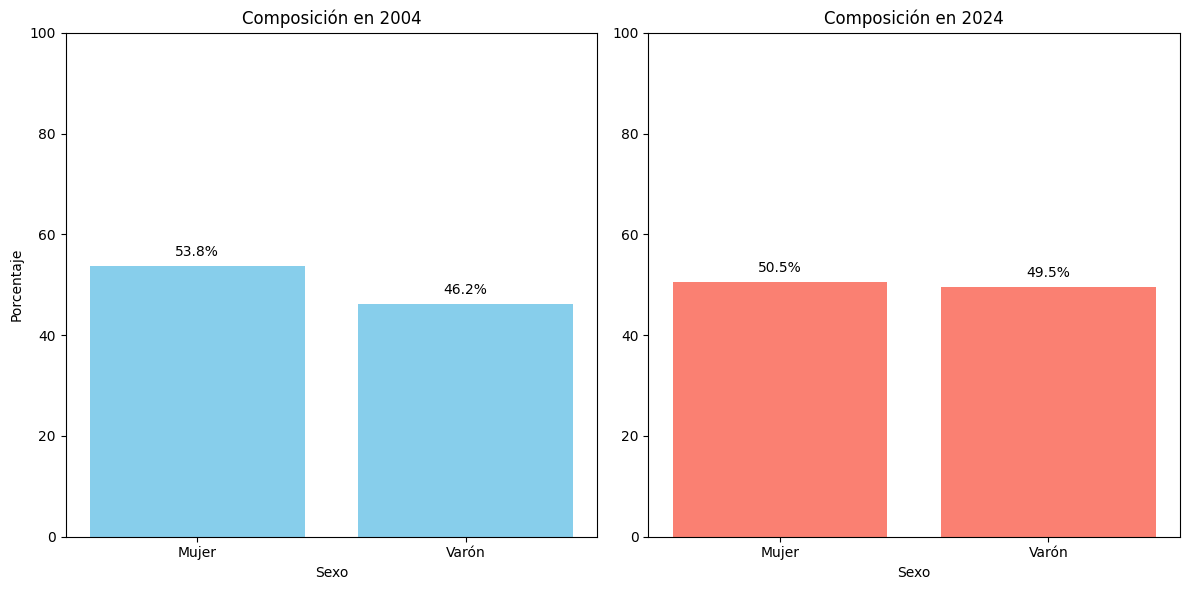

In [15]:
# Graficamos las composiciones por año
composicion_bar(data_2004_counts, data_2024_counts, 'Sexo', './output/composicion_sexo.png')

###  Inciso 2.D
 Objetivo: 
 - Realizar una matriz de correlación para los años 2004 y 2024 para las siguientes variables: CH04, CH06, CH07, CH08, NIVEL ED, ESTADO, CAT_INAC, IPCF 

In [16]:
# Armamos una lista con las columnas que vamos a usar en la matriz de correlación
columnas = ['año', 'ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'estado', 'cat_inac', 'ipcf']

In [17]:
# Función que grafica heatmaps variando los tamaños de los cuadrados, de acuerdo al nivel de correlación (utilizamos link de la consigna)
def heatmap(x, y, size, output_path = None):
    fig, ax = plt.subplots(figsize = (10,8))
    
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), 
        y=y.map(y_to_num), 
        s=size * size_scale,
        marker='s'
    )
    
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    if output_path:
        plt.savefig(output_path)

In [18]:
# Como la mayoría de las variables son catgóricas, para hacer las correlaciones hay que conseguir las dummies
data_dummies = pd.get_dummies(data[columnas], prefix= '', prefix_sep= '')

In [19]:
# Vamos a eliminar las columnas que tienen todo False
data_dummies = data_dummies.loc[:, (data_dummies != 0).any(axis=0)]

In [20]:
# Cambiamos el nombre de las variables para que se vean mejor en la matriz de correlación
data_dummies = data_dummies.rename(columns = {'ipcf': 'Ingreso per cápita Familiar', 'ch06': 'Edad', 'Otros': 'Categoría de Inactividad: Otros'})

In [21]:
# Otra función para heatmaps, pero esta con colores (utilizamos link de la consigna)
def heatmap_from_melted_data(data, x_col, y_col, value_col, cmap=None, size_scale=500, rotation=45, output_path = None):
    """
    Crea un heatmap a partir de datos en formato 'melted' sin etiquetas en las celdas.

    Parámetros:
    - data: DataFrame con los datos en formato 'melted'.
    - x_col: Nombre de la columna para las etiquetas del eje x.
    - y_col: Nombre de la columna para las etiquetas del eje y.
    - value_col: Nombre de la columna con los valores de correlación.
    - cmap: Paleta de colores para el heatmap (opcional).
    - size_scale: Escala para el tamaño de los marcadores (solo para scatter opcional).
    - rotation: Rotación de las etiquetas del eje x.

    Devuelve:
    - ax: Eje de Matplotlib con el heatmap.
    """
    # Crear una matriz para sns.heatmap
    pivoted_data = data.pivot(index=y_col, columns=x_col, values=value_col)
    
    if cmap is None:
        cmap = sns.diverging_palette(20, 220, n=200)
    
    # Dibujar el heatmap sin anotaciones en las celdas
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        pivoted_data,
        cmap=cmap,
        center=0,
        annot=False,  # Desactivar anotaciones en las celdas
        square=True,
        ax=ax
    )
    
    # Configuración de etiquetas
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
   
    # Eliminar nombres de los ejes
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()
    return ax

In [22]:
# Excluimos la columna 'año' antes de calcular las correlaciones
data_dummies_2004 = data_dummies.loc[data_dummies['año'] == 2004].drop(columns=['año']) # Sacamos la variable año para que no aparezca en la matriz

# Calculamos las correlaciones
corr = data_dummies_2004.corr().reset_index().melt(id_vars='index')
corr.columns = ['x', 'y', 'value']  # Modificar nombres de columnas


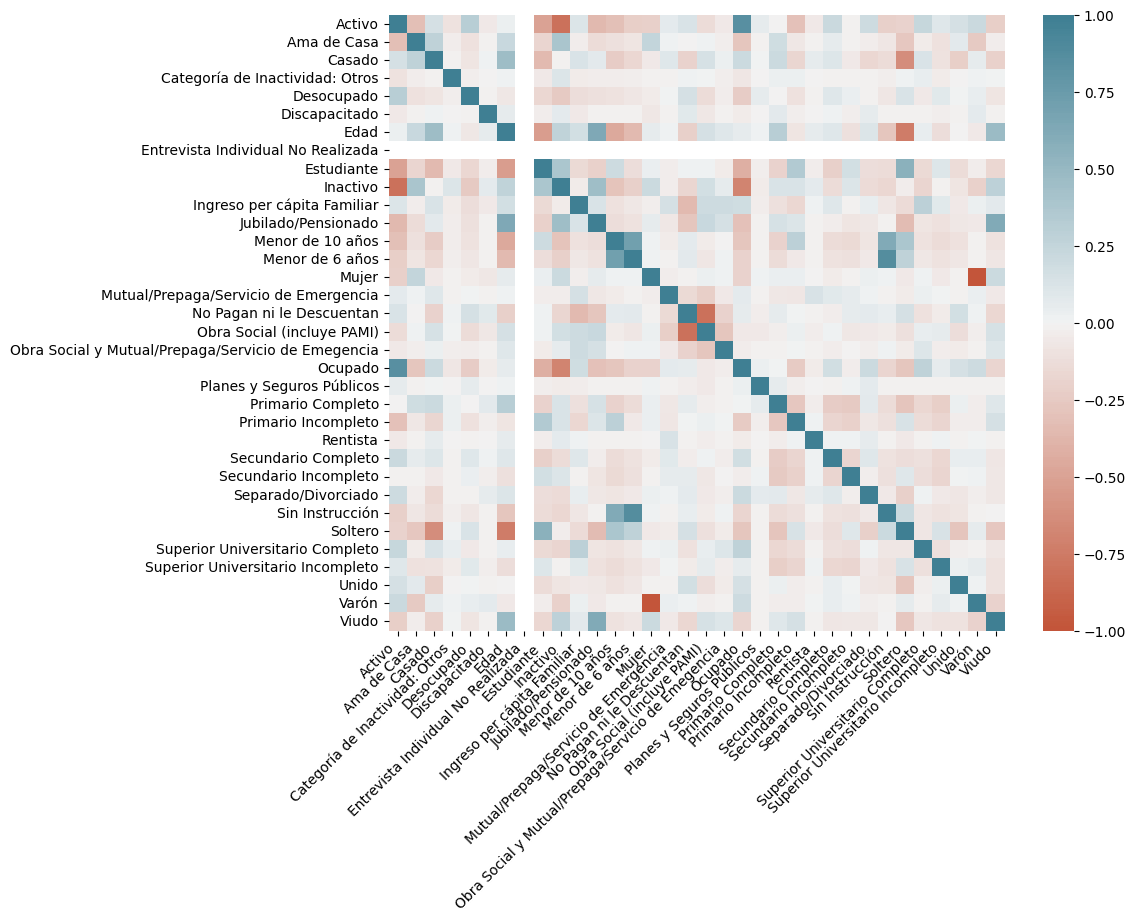

<Axes: >

In [23]:
# Graficamos
heatmap_from_melted_data(
    data=corr,
    x_col='x',
    y_col='y',
    value_col='value',
    output_path= './output/matriz_corr_2004.png'
)

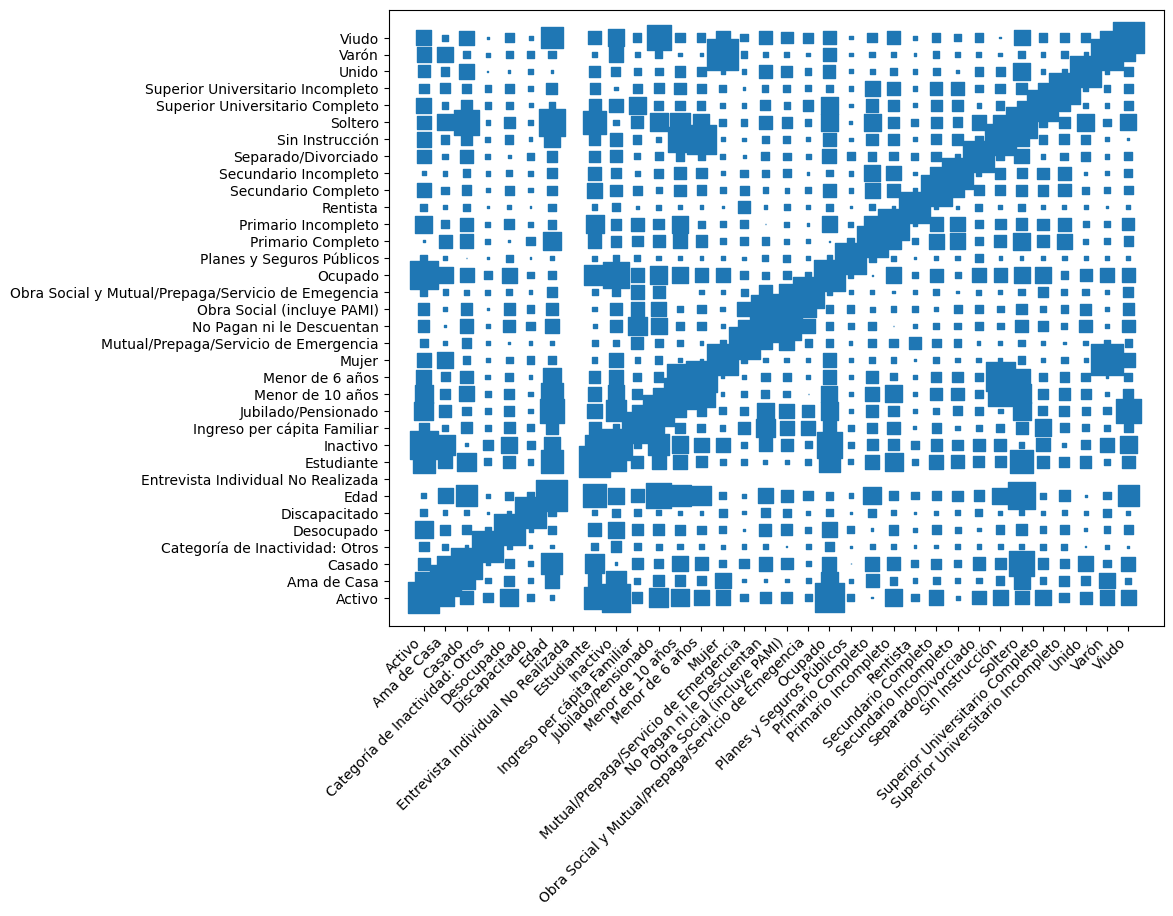

In [24]:
# Excluimos la columna 'año' antes de calcular las correlaciones
filtered_data = data_dummies.loc[data_dummies['año'] == 2004].drop(columns=['año'])

# Calculamos la correlación y transformarla en un DataFrame de tres columnas
corr = filtered_data.corr()  # Saco la correlación
corr = pd.melt(corr.reset_index(), id_vars='index')  # Lo transforma en un df de tres columnas
corr.columns = ['x', 'y', 'value']  # Le cambio el nombre a las columnas

# Creaamos el heatmap
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)


In [25]:
# Excluimos la columna 'año' antes de calcular las correlaciones
filtered_data = data_dummies.loc[data_dummies['año'] == 2024].drop(columns=['año'])

corr = filtered_data.corr()  # Saco la correlación
corr = pd.melt(corr.reset_index(), id_vars='index')  # Lo transforma en un df de tres columnas
corr.columns = ['x', 'y', 'value']  # Le cambio el nombre a las columnas

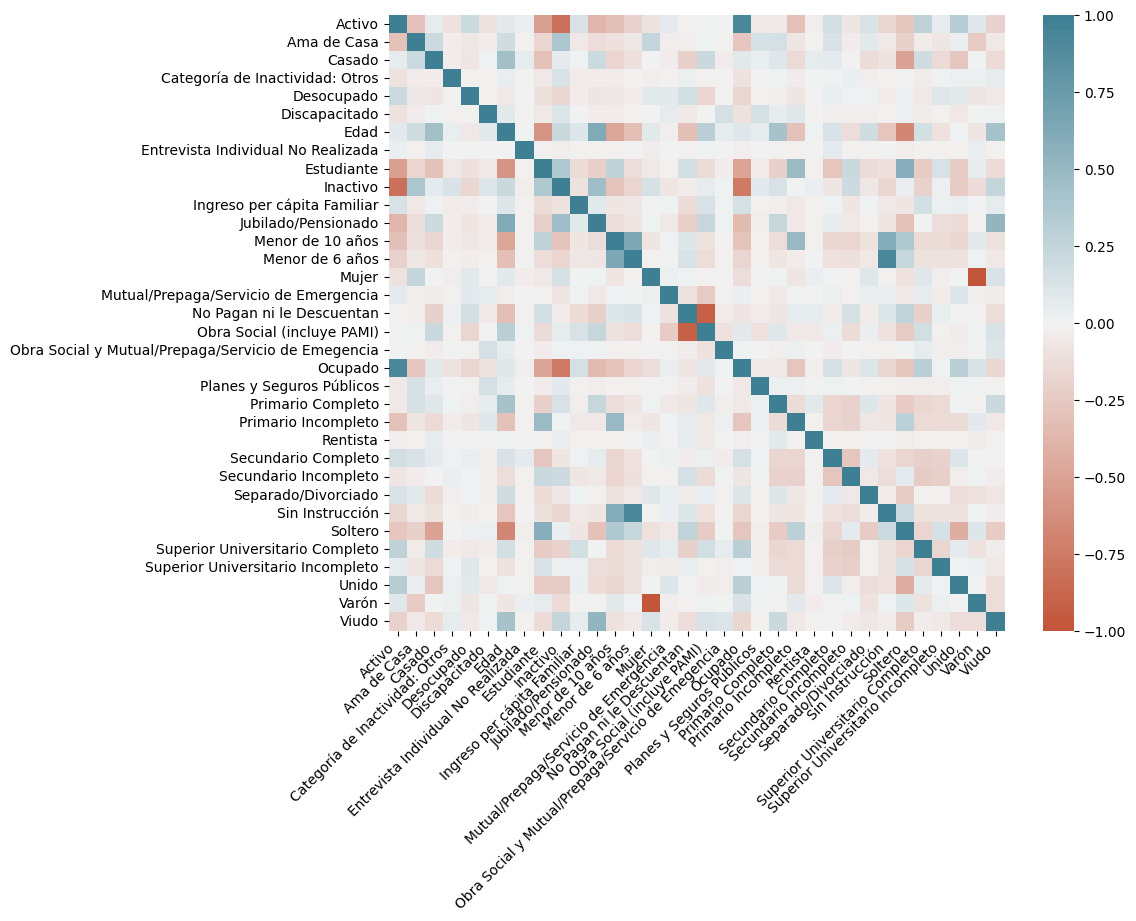

<Axes: >

In [26]:
# Creamos el heatmap
heatmap_from_melted_data(
    data=corr,
    x_col='x',
    y_col='y',
    value_col='value',
    output_path= './output/matriz_corr_2024.png'
)

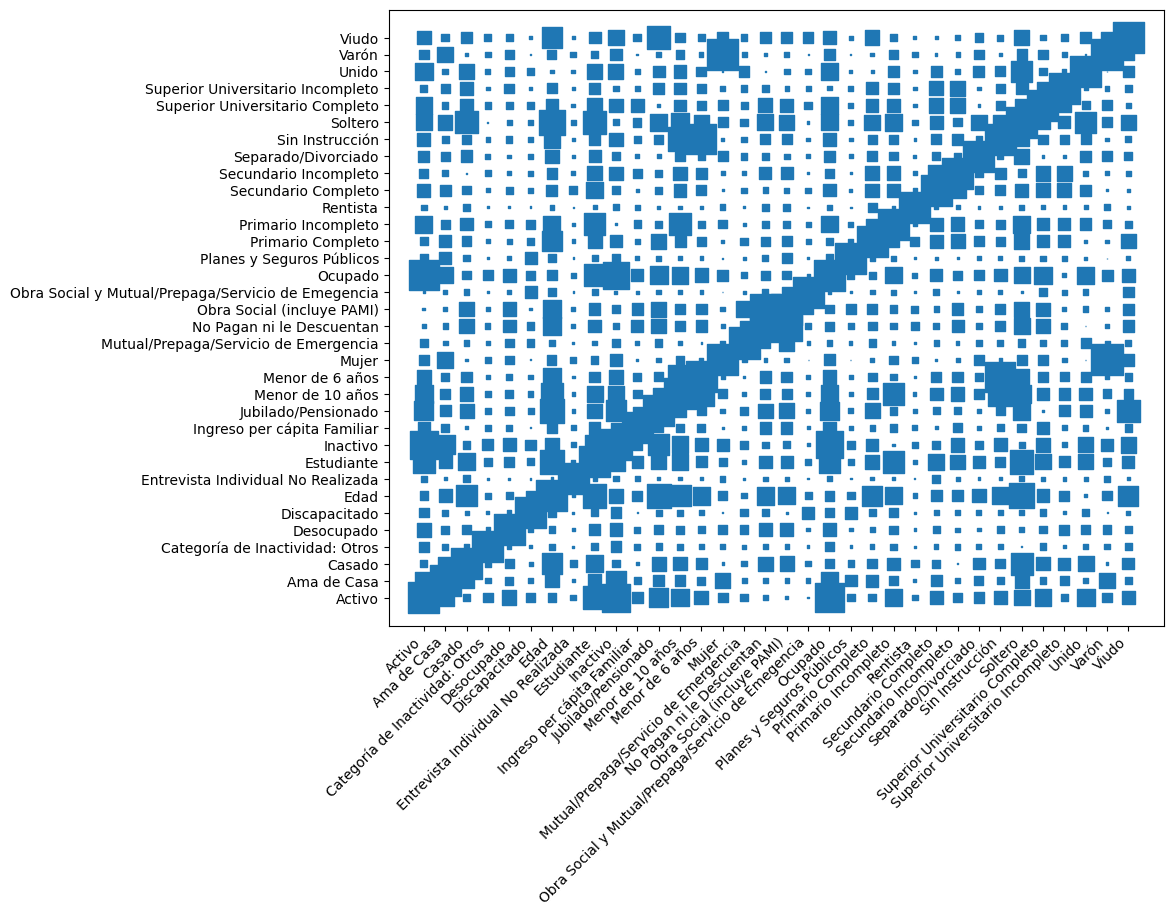

In [27]:
# Filtramos los datos del año 2024 y excluir la columna 'año' antes de calcular las correlaciones
filtered_data = data_dummies.loc[data_dummies['año'] == 2024].drop(columns=['año'])

# Calculamos la matriz de correlaciones
corr = filtered_data.corr()

# Convertimos la matriz de correlaciones en un DataFrame de tres columnas para el heatmap
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']

# Creamos el heatmap
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

### Ejercicio 2.E
Objetivos: 
   - Calcular cantidad de desocupados
   - Calcular cantidad de inactivos
   - Calcular la media del Ingreso Per Cápita Familiar (ipcf) según estado (ocupado, desocupado, inactivo)


In [28]:
agregacion_2004 = data.loc[data['año'] == 2004].groupby('estado', observed= True).agg(count=('ipcf', 'size'),mean_ipcf=('ipcf', 'mean')) # agrupamos los datos por estado y calculamos la media del ipcf para cada estado
agregacion_2004.to_latex('./output/estado_ipcf_mean_2004.tex', index=True, caption="Resumen de IPCF por estado en 2004", label="tab:ipcf_estado_2004")
print(agregacion_2004)

                  count   mean_ipcf
estado                             
Ocupado             440  399.765731
Desocupado           91  206.938540
Inactivo            496  318.462250
Menor de 10 años    117  246.184432


In [29]:
agregacion_2024 = data.loc[data['año'] == 2024].groupby('estado', observed = True).agg(count=('ipcf', 'size'),mean_ipcf=('ipcf', 'mean')) # agrupamos los datos por estado y calculamos la media del ipcf para cada estado
agregacion_2024.to_latex('./output/estado_ipcf_mean_2024.tex', index=True, caption="Resumen de IPCF por estado en 2024", label="tab:ipcf_estado_2004")
print(agregacion_2024)

                                    count      mean_ipcf
estado                                                  
Entrevista Individual No Realizada      1       0.000000
Ocupado                               432  169874.557847
Desocupado                             38  105006.578947
Inactivo                              425  117397.605247
Menor de 10 años                      102   96909.033627


### Inciso 3 
 Objetivos: 
- Calcular cuántas personas no respondieron cuál es su condición de actividad
- Crear una base que contenga únicamente a las personas que respondieron cuál es su condición de actividad
- Crear una base que contenga únicamente a las personas que no respondieron cuál es su condición de actividad

In [30]:
respondieron = data.loc[data['estado'] != 'Entrevista Individual No Realizada'] # creamos base con personas que respondieron su condición de actividad
norespondieron = data.loc[data['estado'] == 'Entrevista Individual No Realizada'] # creamos base con personas que no respondieron su condición de actividad

La cantidad de personas qeu no respondieron sobre su condición de actividad la obtenemos del inciso 2.E

### Inciso 4 
Objetivos: 
- Agregar a la base respondieron una columna llamada PEA (Población Económicamente Activa)
- Realizar un gráfico de barras mostrando la composición por PEA para 2004 y 2024



### Composición PEA

In [31]:
respondieron.loc[:, 'pea'] = np.where(respondieron['estado'].isin(['Ocupado', 'Desocupado']), 1, 0) # creamos la columna. Que valga 1 si estado es Ocupado o Desocupado y que valga 0 de lo contrario
respondieron.loc[:, 'pea'] = respondieron['pea'].astype('category') # pasamos a tipo categórico

C:\Users\HP\AppData\Local\Temp\ipykernel_84432\3583092131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:, 'pea'] = np.where(respondieron['estado'].isin(['Ocupado', 'Desocupado']), 1, 0) # creamos la columna. Que valga 1 si estado es Ocupado o Desocupado y que valga 0 de lo contrario


In [32]:
respondieron_2004_counts = respondieron.loc[respondieron['año']==2004]['pea'].value_counts(normalize=True) * 100 # calculamos composición por pea 2004
respondieron_2024_counts = respondieron.loc[respondieron['año']==2024]['pea'].value_counts(normalize=True) * 100 # calculamos composición por pea 2024

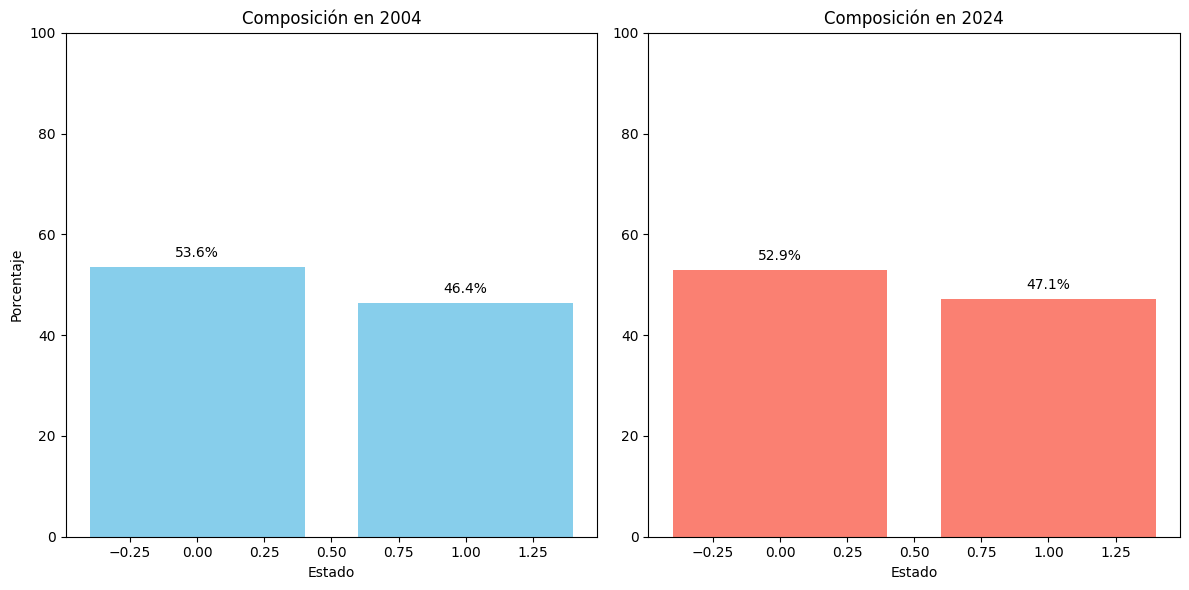

In [33]:
composicion_bar(respondieron_2004_counts, respondieron_2024_counts, 'Estado', './output/composicion_pea.png') # creamos gráfico de barras

### Inciso 5
Objetivos: 
- Agregar a la base respondieron una columna llamada PET (Población en Edad para Trabajar) que toma 1 si el individuo tiene entre 15 y 65 años    cumplidos
- Realizar un gráfico de barras mostrando la composición por PEA para 2004 y 2024. 

### Composición PET

In [34]:
respondieron.loc[:, 'pet'] = np.where((respondieron['ch06'] > 15) & (respondieron['ch06'] < 65), 1, 0) # generamos variable pet con las condiciones pedidas en la consigna
respondieron.loc[:, 'pet'] = respondieron['pet'].astype('category') # pasamos a tipo categórica

C:\Users\HP\AppData\Local\Temp\ipykernel_84432\3349863079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:, 'pet'] = np.where((respondieron['ch06'] > 15) & (respondieron['ch06'] < 65), 1, 0) # generamos variable pet con las condiciones pedidas en la consigna


In [35]:
respondieron_2004_counts = respondieron.loc[respondieron['año']==2004]['pet'].value_counts(normalize=True) * 100 # calculamos composición por pet 2004
respondieron_2024_counts = respondieron.loc[respondieron['año']==2024]['pet'].value_counts(normalize=True) * 100 # calculamos composición por pet 2024

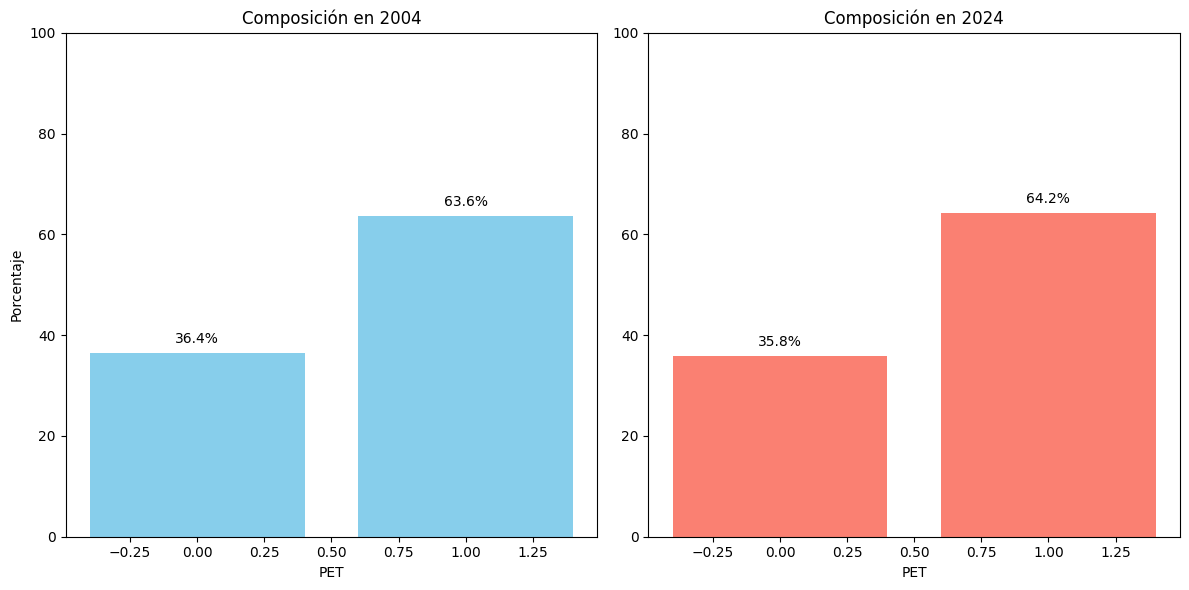

In [36]:
composicion_bar(respondieron_2004_counts, respondieron_2024_counts, 'PET', './output/composicion_pet.png') # graficamos 

### Ejercicio 6.A 

Objetivos: 
- Agregar a la base respondieron una columna llamada desocupado si la persona está desocupada 
- Calculo la cantidad de desocupados por año 
- Mostrar la proporción de desocupados por nivel educativo comparando 2004 vs 2024 


### Desocupados

In [37]:
respondieron.loc[:, 'desocupada'] = np.where(respondieron['estado'].isin(['Desocupado']), 1, 0) # creamos variable desocupado
respondieron.loc[:, 'desocupada'] = respondieron['desocupada'].astype('category') # pasamos a tipo categórica

C:\Users\HP\AppData\Local\Temp\ipykernel_84432\1330017848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:, 'desocupada'] = np.where(respondieron['estado'].isin(['Desocupado']), 1, 0) # creamos variable desocupado


In [38]:
# 2004
total_2004 = respondieron.loc[respondieron['año']==2004].groupby(['nivel_ed'], observed = True)['nivel_ed'].count() # calculamos cantidad de personas por nivel educativo
desocupados_2004 = respondieron.loc[respondieron['año'] == 2004].groupby(['nivel_ed', 'desocupada'], observed = True)['desocupada'].count() # cantidad de desocupados por nivel educativo
proporcion_desocupados_2004 = desocupados_2004 / total_2004 # calculamos proporción de desocupados

proporcion_desocupados_2004 = proporcion_desocupados_2004[proporcion_desocupados_2004.index.get_level_values('desocupada') == 1] # filtramos las filas donde el nivel 'desocupada' es igual a 1
proporcion_desocupados_2004 = proporcion_desocupados_2004.droplevel('desocupada') # eliminamos el nivel de índice 'desocupada' del MultiIndex

proporcion_desocupados_2004 = proporcion_desocupados_2004.reset_index() # reseteamos los índices
proporcion_desocupados_2004.columns = ['Nivel Educativo', 'Proporción'] # renombramos las columnas

proporcion_desocupados_2004.to_latex('./output/nivel_ed_descup_2004.tex', index=True)
print(proporcion_desocupados_2004) # mostramos la tabla

                     Nivel Educativo  Proporción
0                Primario Incompleto    0.019704
1                  Primario Completo    0.076364
2              Secundario Incompleto    0.102564
3                Secundario Completo    0.137500
4  Superior Universitario Incompleto    0.133758
5    Superior Universitario Completo    0.034483


In [39]:
# Mismo procedimiento que en 2004 pero ahora para 2024: 

total_2024 = respondieron.loc[respondieron['año']==2024].groupby('nivel_ed', observed = True)['nivel_ed'].count()
desocupados_2024 = respondieron.loc[respondieron['año'] == 2024].groupby(['nivel_ed', 'desocupada'], observed = True)['desocupada'].count()
proporcion_desocupados_2024 = desocupados_2024 / total_2024

proporcion_desocupados_2024 = proporcion_desocupados_2024[proporcion_desocupados_2024.index.get_level_values('desocupada') == 1]
proporcion_desocupados_2024 = proporcion_desocupados_2024.droplevel('desocupada')

proporcion_desocupados_2024 = proporcion_desocupados_2024.reset_index() 
proporcion_desocupados_2024.columns = ['Nivel Educativo', 'Proporción'] 

proporcion_desocupados_2024.to_latex('./output/nivel_ed_descup_2024.tex', index=True)
print(proporcion_desocupados_2024)

                     Nivel Educativo  Proporción
0                  Primario Completo    0.024793
1              Secundario Incompleto    0.044843
2                Secundario Completo    0.055838
3  Superior Universitario Incompleto    0.085106
4    Superior Universitario Completo    0.012987


### Ejercicio 6.B
Objetivos: 
- Calcular la cantidad de personas desocupadas para cada año     
- Crear una variable categórica de años cumplidos agrupada de a 10 años
- Mostrar la proporción de desocupados por edad agrupada comparando 2004 vs 2024 


In [40]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # creamos los bins de 10 en 10 
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99'] # le ponemos label a cada bin 

respondieron.loc[:, 'edad_categoria'] = pd.cut(respondieron['ch06'], bins=bins, labels=labels, right=False) # creamos la nueva columna edad_categoría

C:\Users\HP\AppData\Local\Temp\ipykernel_84432\3402620258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:, 'edad_categoria'] = pd.cut(respondieron['ch06'], bins=bins, labels=labels, right=False) # creamos la nueva columna edad_categoría


In [41]:
# 2004
total_2004 = respondieron.loc[respondieron['año']==2004].groupby('edad_categoria', observed = True)['edad_categoria'].count() # calculamos la cantidad de personas de cada categoría de edad
desocupados_2004 = respondieron.loc[respondieron['año'] == 2004].groupby(['edad_categoria', 'desocupada'], observed=True)['desocupada'].count() # calculamos la cantidad de personas desocupadas de cada categoría
proporcion_desocupados_2004 = desocupados_2004 / total_2004 # calculamos proporción de desocupados por categoría

proporcion_desocupados_2004 = proporcion_desocupados_2004[proporcion_desocupados_2004.index.get_level_values('desocupada') == 1] # filtramos las filas donde el nivel 'desocupada' es igual a 1
proporcion_desocupados_2004 = proporcion_desocupados_2004.droplevel('desocupada') # eliminamos el nivel de índice 'desocupada' del MultiIndex

proporcion_desocupados_2004 = proporcion_desocupados_2004.reset_index() # reseteamos índice
proporcion_desocupados_2004.columns = ['Categoría de Edad', 'Proporción'] # le ponemos nombres a las columnas

proporcion_desocupados_2004.to_latex('./output/cat_edad_descup_2004.tex', index=True)

print(proporcion_desocupados_2004) # vemos tabla 

  Categoría de Edad  Proporción
0             10-19    0.068421
1             20-29    0.184685
2             30-39    0.097345
3             40-49    0.084507
4             50-59    0.041322
5             60-69    0.082474
6             70-79    0.011765


In [42]:
# 2024: mismo que para 2004
total_2024 = respondieron.loc[respondieron['año']==2024].groupby('edad_categoria', observed = True)['edad_categoria'].count()
desocupados_2024 = respondieron.loc[respondieron['año'] == 2024].groupby(['edad_categoria', 'desocupada'], observed=True)['desocupada'].count()
proporcion_desocupados_2024 = desocupados_2024 / total_2024

proporcion_desocupados_2024 = proporcion_desocupados_2024[proporcion_desocupados_2024.index.get_level_values('desocupada') == 1]
proporcion_desocupados_2024 = proporcion_desocupados_2024.droplevel('desocupada')

proporcion_desocupados_2024 = proporcion_desocupados_2024.reset_index() 
proporcion_desocupados_2024.columns = ['Categoría de Edad', 'Proporción'] 

proporcion_desocupados_2024.to_latex('./output/cat_edad_descup_2024.tex', index=True)

print(proporcion_desocupados_2024)

  Categoría de Edad  Proporción
0             10-19    0.020270
1             20-29    0.089888
2             30-39    0.068702
3             40-49    0.055118
4             50-59    0.019417
5             60-69    0.012048


# Clasificación

El objetivo de esta parte del trabajo es predecir si una persona está desocupada o no utilizando distintas características individuales

### Importamos librerías

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score

### Inciso 2.A

Objetivos: 
- Establecer a "desocupado" como variable dependiente y al resto como independientes
- Partir la base respondieron en una base de entrenamiento y una de test

In [44]:
columnas = ['ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'ipcf'] # definimos variables que nos interesan 

In [45]:
# Definimos para cada año variable explicada
y_2004 = respondieron.loc[respondieron['año']==2004]['desocupada'] 
y_2024 = respondieron.loc[respondieron['año']==2024]['desocupada']

# Definimos para cada año vector de variables explicativas (en formato dummy) 
x_2004 = pd.get_dummies(respondieron.loc[respondieron['año']==2004][columnas])
x_2024 = pd.get_dummies(respondieron.loc[respondieron['año']==2024][columnas])

In [46]:
# Agregamos constantes
x_2004['constante'] = 1
x_2024.loc[:,'constante'] = 1

In [47]:
# Asignamos el 30% de cada base a testeo y por ende el 70% a entrenamiento 
x_train_2004, x_test_2004, y_train_2004, y_test_2004 = train_test_split(x_2004, y_2004, test_size = 0.3, random_state = 101)
x_train_2024, x_test_2024, y_train_2024, y_test_2024 = train_test_split(x_2024, y_2024, test_size = 0.3, random_state = 101)

### Ejercicio 2.B
Objetivos: 
- Implementar los siguientes métodos: Regresión logística, Análisis discriminante lineal, KKN con k=3 y Naive Bayes
- Reportar: matriz de confusión, curva ROC, valores de AUC y de Accuracy de cada uno


In [48]:
# Definimos una función
def evaluate_model(model, X_train, X_test, y_train, y_test): # los inputs de la función son los datos de testeo y de entrenamiento
    model.fit(X_train, y_train) # ajustamos el modelo para la base de entrenamiento
    
    y_pred = model.predict(X_test) # predecimos y con los datos de la base de entrenamiento
    y_prob = model.predict_proba(X_test)[:, 1] # predecimos la probabilidad de que y esté en una clase
    
    cm = confusion_matrix(y_test, y_pred) # matriz de confusión
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) # curva ROC 
    auc = roc_auc_score(y_test, y_prob) # AUC
    
    accuracy = accuracy_score(y_test, y_pred) # accuracy score
    
    return cm, fpr, tpr, auc, accuracy # que devuelva todos los valores

In [49]:
# Definimos los modelos a utilizar
models = {
    'Regresión Logística': LogisticRegression(max_iter= 10000),
    'Análisis Discriminante Lineal': LinearDiscriminantAnalysis(),
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'Naive Bayes': GaussianNB()
}

In [50]:
## 2004: Imprimimos todos los resultados pedidos en la consigna 
results = {}
print("Resultados para 2004:")
for model_name, model in models.items():
    cm, fpr, tpr, auc, accuracy = evaluate_model(model, x_train_2004, x_test_2004, y_train_2004, y_test_2004)
    results[model_name] = {
        'Matriz de Confusión': cm,
        'AUC': auc,
        'Accuracy': accuracy,
        'FPR': fpr,
        'TPR': tpr
    }

    print(f"{model_name}:")
    print(f"Matriz de Confusión:\n{cm}")
    print(f"AUC: {auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}\n")


Resultados para 2004:


Regresión Logística:
Matriz de Confusión:
[[312   0]
 [ 32   0]]
AUC: 0.80
Accuracy: 0.91

Análisis Discriminante Lineal:
Matriz de Confusión:
[[311   1]
 [ 32   0]]
AUC: 0.83
Accuracy: 0.90

KNN (k=3):
Matriz de Confusión:
[[302  10]
 [ 26   6]]
AUC: 0.65
Accuracy: 0.90

Naive Bayes:
Matriz de Confusión:
[[143 169]
 [  4  28]]
AUC: 0.78
Accuracy: 0.50



### Curva ROC

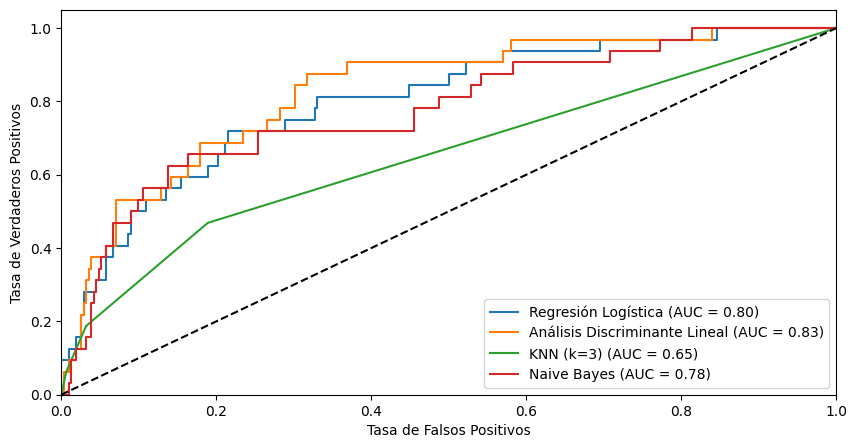

In [51]:
# Graficamos la curva ROC 
plt.figure(figsize=(10, 5)) # crea una figura con tamaño 10x5 
for model_name, metrics in results.items(): # itera sobre cada modelo y sus métricas
    plt.plot(metrics['FPR'], metrics['TPR'], label=f'{model_name} (AUC = {metrics["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # grafica linea diagonal 
plt.xlim([0.0, 1.0]) # ajustamos escala eje x
plt.ylim([0.0, 1.05]) # ajustamos escala eje y 
plt.xlabel('Tasa de Falsos Positivos') # label eje x
plt.ylabel('Tasa de Verdaderos Positivos') # label eje y 
plt.legend(loc='lower right') # leyenda

plt.savefig('./output/roc_2004.png')
plt.show() # que muestre la curva ROC

### 2024

In [52]:
# Hacemos lo mismo para el 2024: 
results.clear() # Limpiamos el diccionario con los resultados del 2004
print("Resultados para 2024:")
for model_name, model in models.items():
    cm, fpr, tpr, auc, accuracy = evaluate_model(model, x_train_2024, x_test_2024, y_train_2024, y_test_2024)
    results[model_name] = {
        'Matriz de Confusión': cm,
        'AUC': auc,
        'Accuracy': accuracy,
        'FPR': fpr,
        'TPR': tpr
    }

    print(f"{model_name}:")
    print(f"Matriz de Confusión:\n{cm}")
    print(f"AUC: {auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}\n")

Resultados para 2024:
Regresión Logística:
Matriz de Confusión:
[[290   0]
 [ 10   0]]
AUC: 0.74
Accuracy: 0.97

Análisis Discriminante Lineal:
Matriz de Confusión:
[[289   1]
 [ 10   0]]
AUC: 0.77
Accuracy: 0.96

KNN (k=3):
Matriz de Confusión:
[[286   4]
 [ 10   0]]
AUC: 0.55
Accuracy: 0.95

Naive Bayes:
Matriz de Confusión:
[[290   0]
 [ 10   0]]
AUC: 0.69
Accuracy: 0.97



### Curva ROC

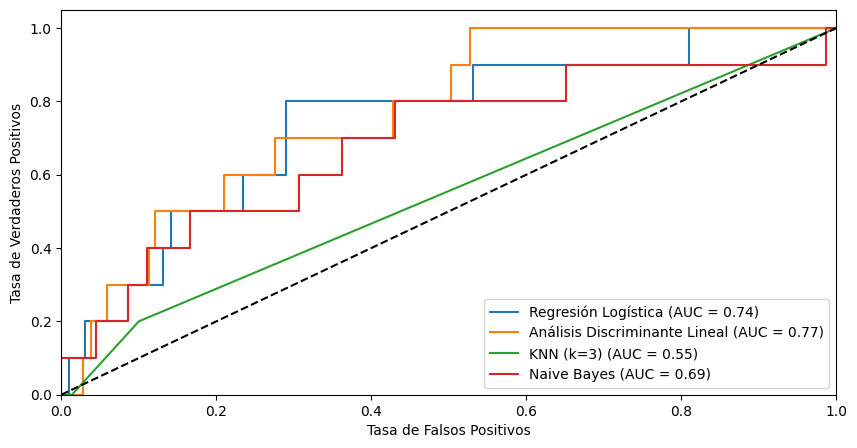

In [53]:
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], label=f'{model_name} (AUC = {metrics["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')

plt.savefig('./output/roc_2024.png')
plt.show()

### Ejercicio 2.C

La explicación se encuentra en el documento. 

### Ejercicio 2.D 

Objetivos: 
    - Con el método seleccionado en el inciso 3, predecir qué personas de la base norespondieron son desocupadas
    - Mostrar proporción de personas de la base norespondieron que están desocupadas

## Predecir en No Respondieron

Tenemos una única observación para norespondieron

In [54]:
norespondieron_dummies = pd.get_dummies(norespondieron[columnas]) # agregamos las dummies a la base no respondieron
norespondieron_dummies.loc[:, 'constante'] = 1 # agregamos constante 

In [55]:
ld = LinearDiscriminantAnalysis() # Corremos el modelo logístico 
ld.fit(x_train_2024, y_train_2024) # ajusta a los datos de entrenamiento 
    
y_pred = ld.predict(norespondieron_dummies) # predice 
print(y_pred)

[0]


Predice que no va a estar desocupada esta persona